In [1]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize

# Aucution environment

In [2]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [3]:
class GeneralizedFirstPriceAuction(Auction):
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        winners_values = adv_values[winners]
        return winners, winners_values
    
    def get_payments_per_click(self, winners, winners_values, bids): # Little change, here I pass directly 'winners_values', instead of 'values' and then 'values[winners]' 
        payments = winners_values/self.ctrs[winners] # Publisher entries
        return payments.round(2)

    def simulate_jumps(self, mu_pois = 3, mu_norm = 200):
        jum_num = np.clip(np.random.poisson(mu_pois), 1, 10)
        users_num_between_jumps = np.round(np.random.normal(mu_norm, 25, size = jum_num))

        total_users = int(users_num_between_jumps.sum())

        return jum_num, users_num_between_jumps, total_users
        

### Possible alternative bidding strategy

In [4]:
### Adversarial Bidders
# non-trivial scenario: competitors sample bids from a uniform with range varying over time
#pattern = lambda t: 1-np.abs(np.sin(8*t/n_users))
#other_bids = np.array([np.random.uniform(0, pattern(t), size = n_adv) for t in range(n_users)]).T
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

#m_t = np.sort(other_bids, axis=0)[-n_slots] # To win it's sufficient that our bid is grater or equal than the n_slot-th biggest bid

#plt.figure(figsize=(20, 5))
#plt.plot(m_t)
#plt.title('Expected maximum bid')
#plt.xlabel('$t$')
#plt.ylabel('$m_t$')
#plt.show()

# Agents

## Hedge

In [4]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

## Full Feedback Multiplicative Pacing 

In [5]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]
    
    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

# FFMultiplicativePacing Agents Interactions

## Fair budget (B = n_users/2)

In [12]:
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([1, 1, 1]) # case in which all the slots are equivalent

# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.array([0.8, 0.65, 0.50, 0.75])
v = np.array([0.7, 1.1, 1.4, 0.85])

std_bid = 0.05
mu_parameters = np.array([0.5]) # starting value for beta is -5
S =  0.1# Varianace of the Normal for the beta_parameter variations during shock days 
s = 0.0001

auction = GeneralizedFirstPriceAuction(ctrs=ctrs, lambdas=lmbd)
# environmental settings
jum_num, users_num_between_jumps, n_users = auction.simulate_jumps()
jump_users = np.cumsum(users_num_between_jumps)


B = n_users/2
rho = B/n_users
my_valuation = 0.6


other_bids = np.clip(np.random.normal(mu_parameters[-1], std_bid, size=(n_adv, 1)), 0, 1)


for u in range(n_users):
    if u in jump_users:
        mu_variation = np.random.normal(0, S)
        mu_parameter = mu_parameters[-1] +  mu_variation

    else:
        mu_variation = np.random.normal(0, s)
        mu_parameter = mu_parameters[-1] +  mu_variation

    mu_parameters = np.append(mu_parameters, mu_parameter)

    other_bids_daily = np.clip(np.random.normal(mu_parameters[-1], std_bid, size=(n_adv, 1)), 0, 1)
    other_bids = np.append(other_bids, other_bids_daily, axis=1)
    
m_t = np.sort(other_bids, axis=0)[-n_slots] # To win it's sufficient that our bid is grater or equal than the n_slot-th biggest bid

available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

#
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

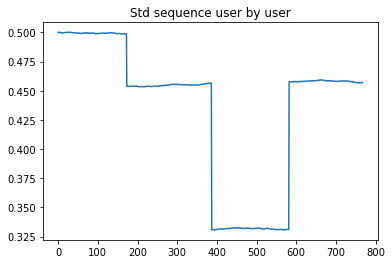

array([172., 386., 581.])

In [13]:
# History of the std parameter
plt.figure()
plt.plot(np.linspace(0, n_users, n_users+1),mu_parameters)
plt.title('Std sequence user by user')
plt.show()

#jump_users = np.cumsum(users_num_between_jumps)

np.cumsum(users_num_between_jumps[:-1]) # Because the last is the end

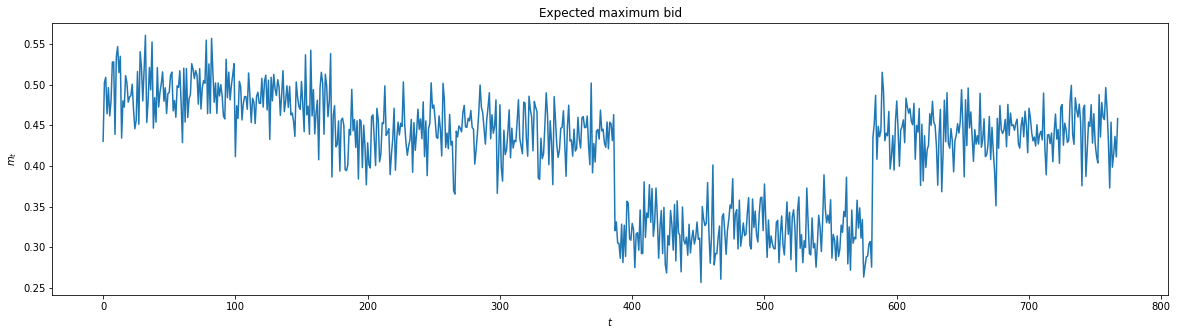

In [14]:
# Expected maximum bid
plt.figure(figsize=(20, 5))
plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

### One trial only

In [15]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(0 in winners) # change, here we have more than one winner, so it's sufficient that I (index 0) am between them
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 313


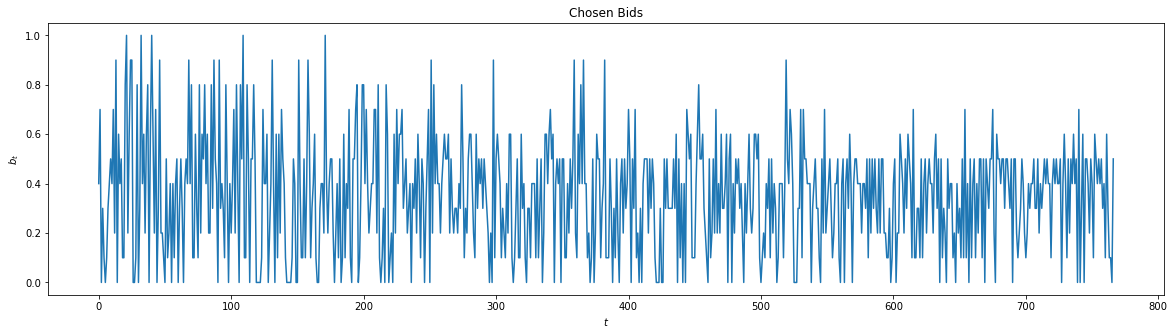

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

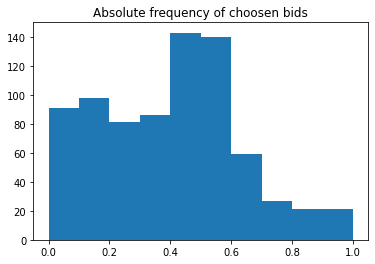

In [17]:
plt.figure()
plt.hist(my_bids)
plt.title('Absolute frequency of choosen bids')
plt.show()

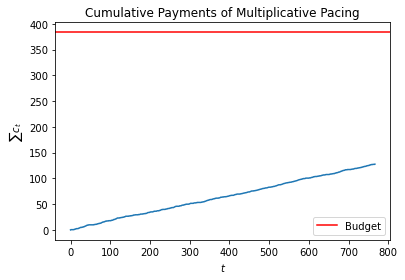

In [18]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

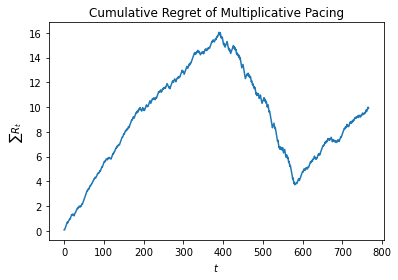

In [19]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

### More trials

In [20]:
n_epochs = 50
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(0 in winners)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

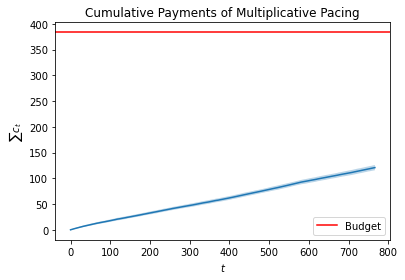

In [21]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

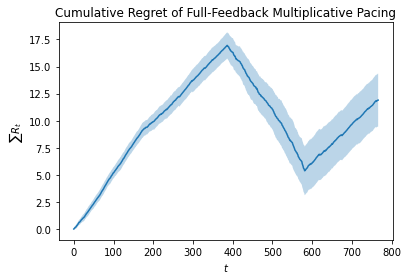

In [22]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

**Comment:**  
Using a fair budget, that is B = n_user/2, such that at each round our agent could offer 0.5 (remember that the adversaries bids are sampled from a normal with 0.5 mean, plus perturbation), the FFMP agents wins more ore less 1/3 of the auctions, that's not bad, considering that there are 4 other bidders and he doens't deplete the budget.

## Low budget (B = n_users/10)

In [25]:
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([1, 1, 1]) # case in which all the slots are equivalent

# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.array([0.8, 0.65, 0.50, 0.75])
v = np.array([0.7, 1.1, 1.4, 0.85])

std_bid = 0.05
mu_parameters = np.array([0.5]) # starting value for beta is -5
S =  0.1# Varianace of the Normal for the beta_parameter variations during shock days 
s = 0.0001

auction = GeneralizedFirstPriceAuction(ctrs=ctrs, lambdas=lmbd)
# environmental settings
jum_num, users_num_between_jumps, n_users = auction.simulate_jumps()
jump_users = np.cumsum(users_num_between_jumps)


B = n_users/10 
rho = B/n_users
my_valuation = 0.6


other_bids = np.clip(np.random.normal(mu_parameters[-1], std_bid, size=(n_adv, 1)), 0, 1)


for u in range(n_users):
    if u in jump_users:
        mu_variation = np.random.normal(0, S)
        mu_parameter = mu_parameters[-1] +  mu_variation

    else:
        mu_variation = np.random.normal(0, s)
        mu_parameter = mu_parameters[-1] +  mu_variation

    mu_parameters = np.append(mu_parameters, mu_parameter)

    other_bids_daily = np.clip(np.random.normal(mu_parameters[-1], std_bid, size=(n_adv, 1)), 0, 1)
    other_bids = np.append(other_bids, other_bids_daily, axis=1)
    
m_t = np.sort(other_bids, axis=0)[-n_slots] # To win it's sufficient that our bid is grater or equal than the n_slot-th biggest bid

available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

#
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

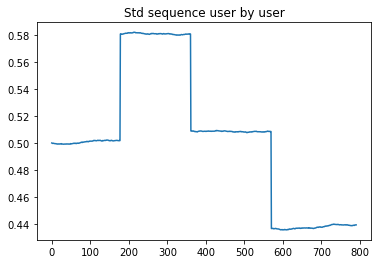

array([177., 360., 569.])

In [26]:
# History of the std parameter
plt.figure()
plt.plot(np.linspace(0, n_users, n_users+1),mu_parameters)
plt.title('Std sequence user by user')
plt.show()

#jump_users = np.cumsum(users_num_between_jumps)

np.cumsum(users_num_between_jumps[:-1]) # Because the last is the end

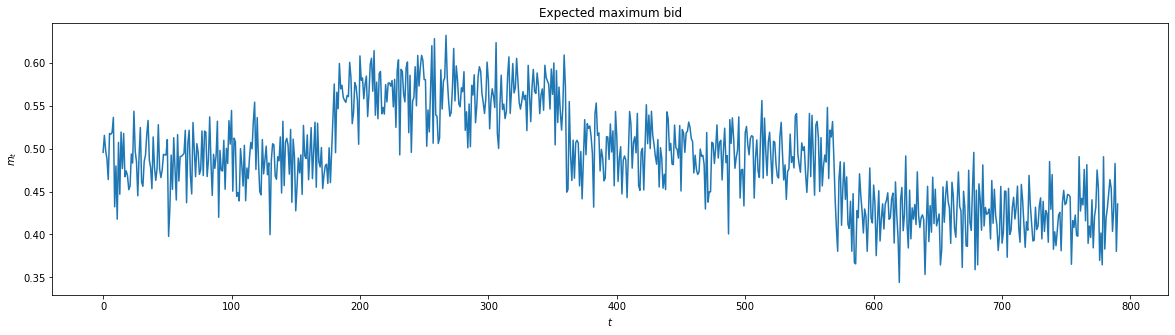

In [27]:
# Expected maximum bid
plt.figure(figsize=(20, 5))
plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

### One trial only

In [28]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(0 in winners) # change, here we have more than one winner, so it's sufficient that I (index 0) am between them
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 149


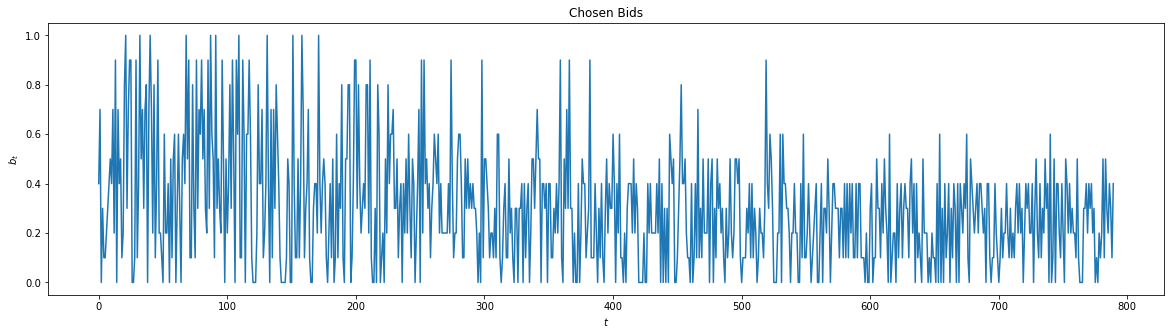

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

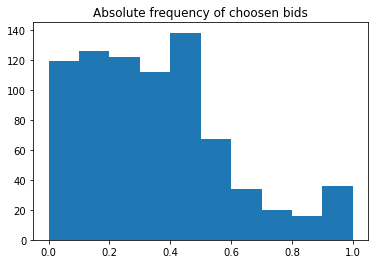

In [30]:
plt.figure()
plt.hist(my_bids)
plt.title('Absolute frequency of choosen bids')
plt.show()

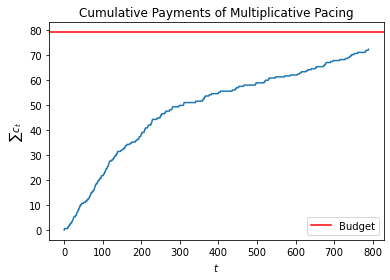

In [31]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

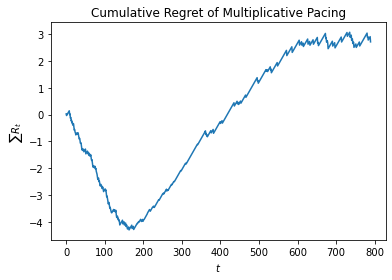

In [32]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

### More trials

In [33]:
n_epochs = 50
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(0 in winners)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

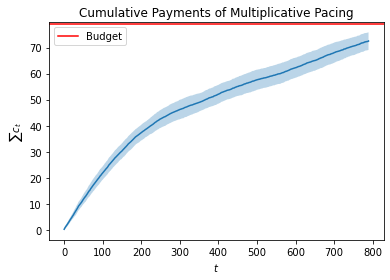

In [34]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

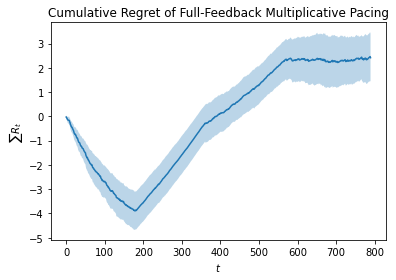

In [35]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

## Same but with increasing jumps

In [103]:
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([1, 1, 1]) # case in which all the slots are equivalent

# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.array([0.8, 0.65, 0.50, 0.75])
v = np.array([0.7, 1.1, 1.4, 0.85])

std_bid = 0.05
mu_parameters = np.array([0.5]) # starting value for beta is -5
S =  0.1# Varianace of the Normal for the beta_parameter variations during shock days 
s = 0.0001

auction = GeneralizedFirstPriceAuction(ctrs=ctrs, lambdas=lmbd)
# environmental settings
jum_num, users_num_between_jumps, n_users = auction.simulate_jumps()
jump_users = np.cumsum(users_num_between_jumps)


B = n_users/10 
rho = B/n_users
my_valuation = 0.6


other_bids = np.clip(np.random.normal(mu_parameters[-1], std_bid, size=(n_adv, 1)), 0, 1)


for u in range(n_users):
    if u in jump_users:
        mu_variation = np.random.normal(0, S)
        mu_parameter = mu_parameters[-1] +  mu_variation

    else:
        mu_variation = np.random.normal(0, s)
        mu_parameter = mu_parameters[-1] +  mu_variation

    mu_parameters = np.append(mu_parameters, mu_parameter)

    other_bids_daily = np.clip(np.random.normal(mu_parameters[-1], std_bid, size=(n_adv, 1)), 0, 1)
    other_bids = np.append(other_bids, other_bids_daily, axis=1)
    
m_t = np.sort(other_bids, axis=0)[-n_slots] # To win it's sufficient that our bid is grater or equal than the n_slot-th biggest bid

available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

#
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

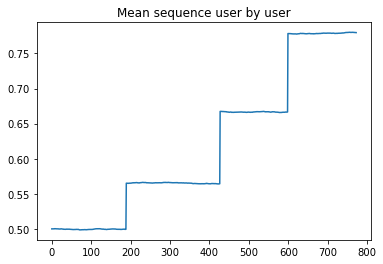

array([188., 426., 598.])

In [104]:
# History of the std parameter
plt.figure()
plt.plot(np.linspace(0, n_users, n_users+1),mu_parameters)
plt.title('Mean sequence user by user')
plt.show()

#jump_users = np.cumsum(users_num_between_jumps)

np.cumsum(users_num_between_jumps[:-1]) # Because the last is the end

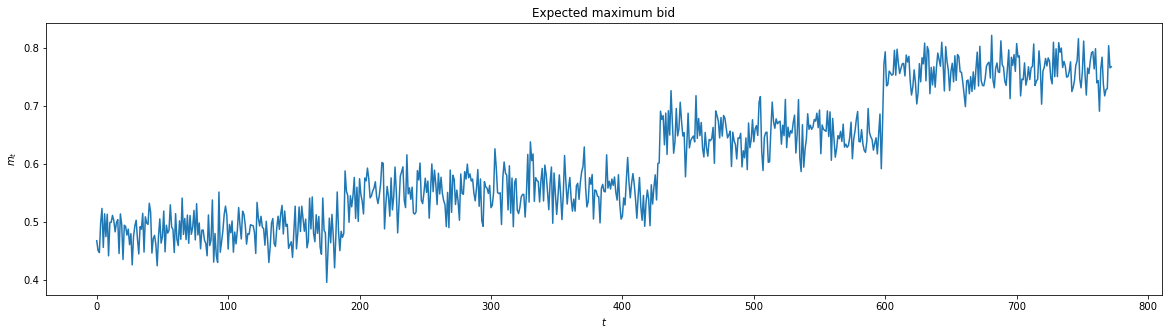

In [105]:
# Expected maximum bid
plt.figure(figsize=(20, 5))
plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

### One trial only

In [106]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(0 in winners) # change, here we have more than one winner, so it's sufficient that I (index 0) am between them
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 108


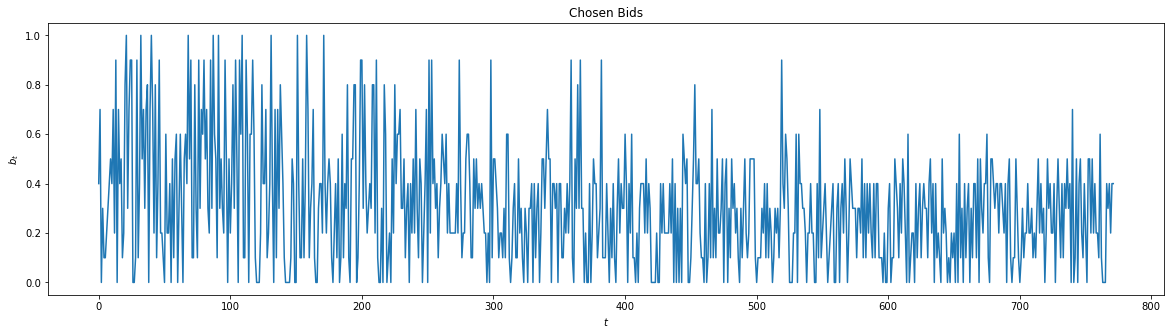

In [107]:
plt.figure(figsize=(20, 5))
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

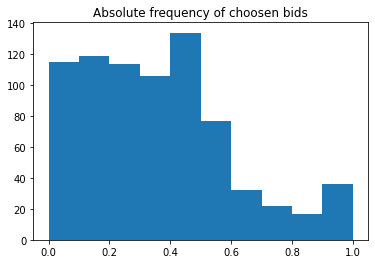

In [108]:
plt.figure()
plt.hist(my_bids)
plt.title('Absolute frequency of choosen bids')
plt.show()

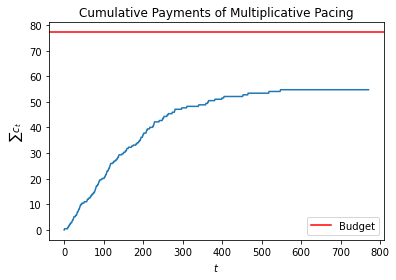

In [109]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

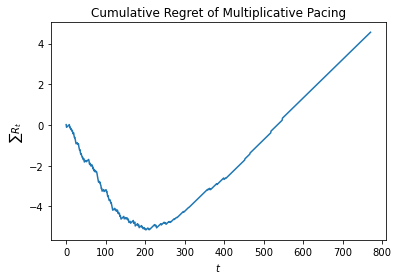

In [110]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

### More trials

In [111]:
n_epochs = 50
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(0 in winners)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

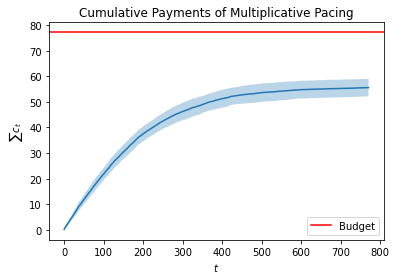

In [112]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

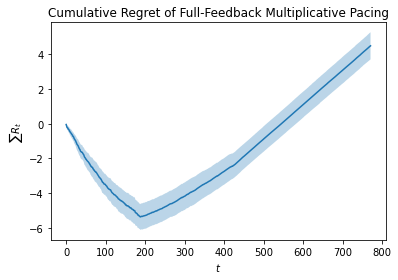

In [113]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

**Comment:**  
Using an unfair budget, that is B = n_user/10, such that at each round our agent could offer 0.1 (remember that the adversaries bids are sampled from a normal with 0.5 mean, plus perturbation), the FFMP agents wins slightly less than 1/5 of the auctions, that's not bad, considering that there are 4 other bidders with greater budget; one other strong agent good feature to notice is that, even if he has lower budget he doesn't deplete it.

## High budget (B = n_users)

In [120]:
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([1, 1, 1]) # case in which all the slots are equivalent

# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.array([0.8, 0.65, 0.50, 0.75])
v = np.array([0.7, 1.1, 1.4, 0.85])

std_bid = 0.05
mu_parameters = np.array([0.5]) # starting value for beta is -5
S =  0.1# Varianace of the Normal for the beta_parameter variations during shock days 
s = 0.0001

auction = GeneralizedFirstPriceAuction(ctrs=ctrs, lambdas=lmbd)
# environmental settings
jum_num, users_num_between_jumps, n_users = auction.simulate_jumps()
jump_users = np.cumsum(users_num_between_jumps)


B = n_users
rho = B/n_users
my_valuation = 0.6


other_bids = np.clip(np.random.normal(mu_parameters[-1], std_bid, size=(n_adv, 1)), 0, 1)


for u in range(n_users):
    if u in jump_users:
        mu_variation = np.random.normal(0, S)
        mu_parameter = mu_parameters[-1] +  mu_variation

    else:
        mu_variation = np.random.normal(0, s)
        mu_parameter = mu_parameters[-1] +  mu_variation

    mu_parameters = np.append(mu_parameters, mu_parameter)

    other_bids_daily = np.clip(np.random.normal(mu_parameters[-1], std_bid, size=(n_adv, 1)), 0, 1)
    other_bids = np.append(other_bids, other_bids_daily, axis=1)
    
m_t = np.sort(other_bids, axis=0)[-n_slots] # To win it's sufficient that our bid is grater or equal than the n_slot-th biggest bid

available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

#
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

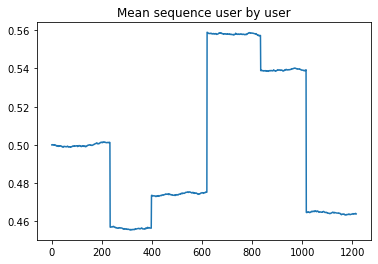

array([ 232.,  397.,  619.,  833., 1015.])

In [121]:
# History of the mean parameter
plt.figure()
plt.plot(np.linspace(0, n_users, n_users+1),mu_parameters)
plt.title('Mean sequence user by user')
plt.show()

#jump_users = np.cumsum(users_num_between_jumps)

np.cumsum(users_num_between_jumps[:-1]) # Because the last is the end

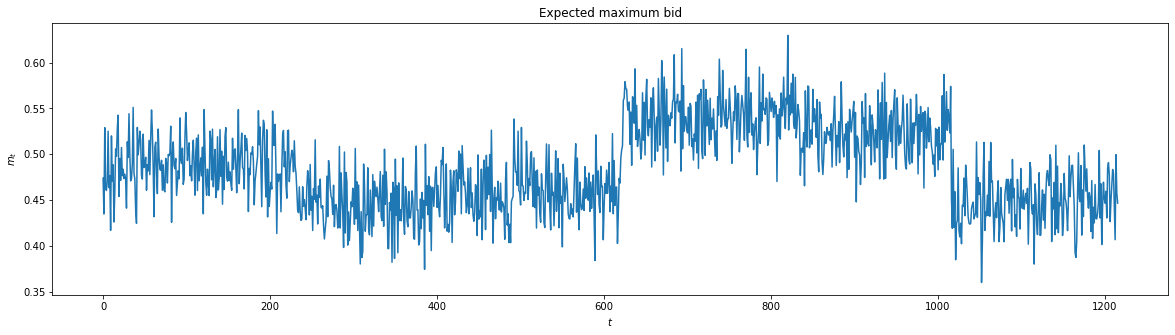

In [122]:
# Expected maximum bid
plt.figure(figsize=(20, 5))
plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

### One trial only

In [123]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(0 in winners) # change, here we have more than one winner, so it's sufficient that I (index 0) am between them
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 374


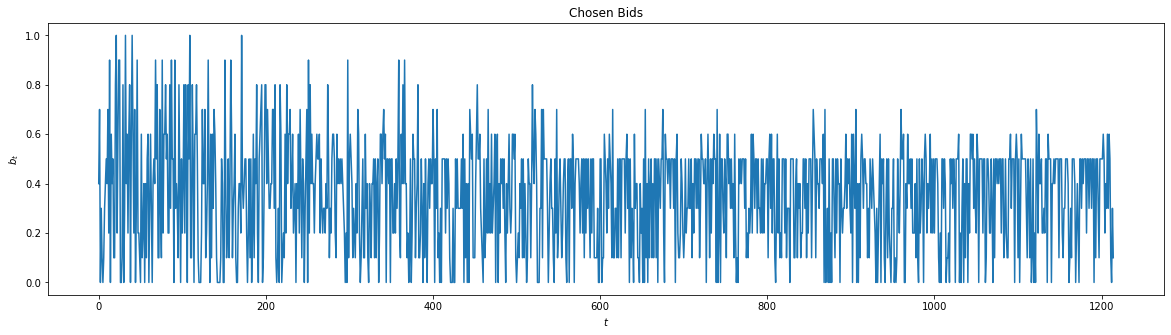

In [124]:
plt.figure(figsize=(20, 5))
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

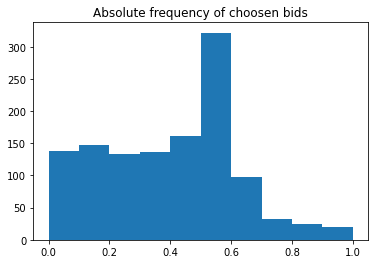

In [125]:
plt.figure()
plt.hist(my_bids)
plt.title('Absolute frequency of choosen bids')
plt.show()

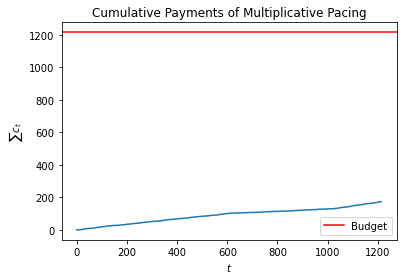

In [126]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

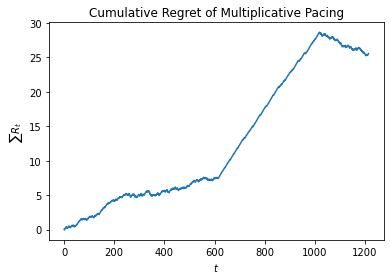

In [127]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

### More trials

In [128]:
n_epochs = 50
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(0 in winners)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

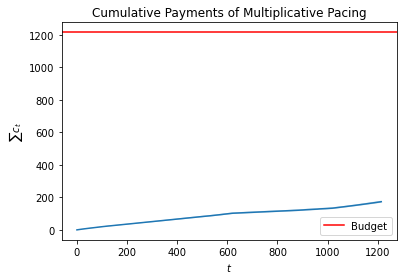

In [129]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

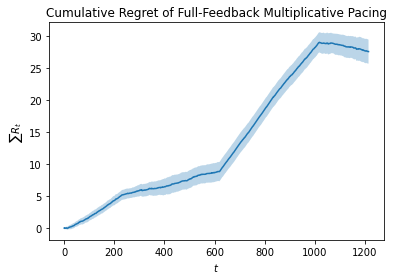

In [130]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

**Comment:**  
Using a bigger budget, that is B = n_user, such that at each round our agent could offer 1 (remember that the adversaries bids are sampled from a normal with 0.5 mean, plus perturbation), the FFMP agents wins slightly less than 1/3 of the auctions, that's not bad, considering that there are 4 other bidders and he doens't deplete the budget at all.